### Our approach: orthogonal greedy algorithm 

**OGA:**
\begin{equation} 
			f_0 = 0, \quad g_n  = \mathop{\arg \max}_{g \in \mathbb{D}}  | \langle g, f - f_{n-1}
			\rangle |, \quad f_n = P_n(f),  
		\end{equation}
		where $P_n$ is a projection onto $H_n = \text{span}\{g_1, g_2,...,g_n \}$
		 For 1D $L^2$-fitting for target $f(x)$ with $f(0) = 0$, the ReLU shallow neural network dictionary can be given by 
		\begin{equation}
			\mathbb{D} = \{ \sigma( x + b), b \in [-\pi,\pi]  \}, ~~~ \sigma(x) = \max(0,x)
		\end{equation}
        


**Theretically guaranteed convergence rate:** 

Let the iterates $f_n$ be given by the orthogonal greedy algorithm, where $f\in \mathcal{V}_1(\mathbb{P}_k^d)$, where $\mathbb{P}_k^d$ is the $\text{ReLU}^k$ dictionary, $\sigma_k(\omega \cdot x + b)$,  $\sigma(x) = \max^k(0,x)$

Then we have
  \begin{equation}
   \|f_n - f\|_{L^2} \lesssim \|f\|_{\mathcal{V}_1(\mathbb{P}_k^d)}n^{-\frac{1}{2} - \frac{2k+1}{2d}}.
  \end{equation}
  
 **In particular**, for a ReLU shallow neural network in 1D, we have ($k=1, d=1$)
   \begin{equation}
   \|f_n - f\|_{L^2} \lesssim \|f\|_{\mathcal{V}_1(\mathbb{P}_1^1)}n^{-2}.
  \end{equation}
  

**Two major steps in OGA**:

1. argmax 
2. projection

**How to implement the two major steps in OGA?**

1. Solve the argmax problem
    - $L^2$ innner product: numerical integration 
        - Piecewise Gauss quadrature (very accurate numerical quadrature is needed for this part)
    - Method of exhaustion for 1D for a good initial guess 
        - $\mathbb{D}_N = \{ \sigma(x + b_i), b_i =\pi -  2 \pi\frac{i-1}{N} \}_{i = 1}^N$
    - Further optimization using Newton's method to get a better $g_n$ (This part is also essential when the number of neuron is large)
    
2. Orthogonal projection. Given $H_n = \text{span}\{g_1, g_2,...,g_n \}$
    - Some mathematics derivation here for the linear system
         - $<f_n,g_i> = <f,g_i>$ for all $i= 1,2,...,n$, with $f_n = \sum_{i=1}^n a_i g_i $
         - A liner system in $\alpha := (a_1, a_2,...,a_n)^T$. $M \alpha = b$, where $M_{i,j} = <g_j,g_i>$ $b_i = <f,g_i> $
         - Equivalently, an $L^2$-fitting: $\min_{a_1, a_2,...,a_n} \frac{1}{2} \|\sum_{i=1}^n a_i g_i  - f \|^2_{L^2} $, that is $\min_{\alpha \in \mathbb{R}^n} \frac{1}{2} \alpha^T M \alpha - b^T \alpha $
    - A shortcut: make use of pytorch automatic differentiation to get the matrix M, since we already know how to compute the loss function very accurately.



In [6]:
# Helper functions
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
from scipy.sparse import linalg
from pathlib import Path
pi = torch.tensor(np.pi,dtype=torch.float64)
torch.set_default_tensor_type(torch.DoubleTensor)
import matplotlib.pyplot as plt 

if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu"  
    

# 5 Point Gauss Quadrature rule, defined as global variables 
gx = torch.tensor([-0.9061798459386639927976, -0.5384693101056830910363, 0, 0.5384693101056830910363, 
     0.9061798459386639927976]).to(device)
gx = gx.view(1,-1)
gw = torch.tensor([0.2369268850561890875143, 0.4786286704993664680413, 0.5688888888888888888889, 0.4786286704993664680413,
     0.2369268850561890875143]).to(device)
gw = gw.view(-1,1) # Column vector

def plot_l2_error_history(alg_name,hidden_size1,err): 
    plt.figure(dpi = 100)
    plt.title(alg_name + ': neuron number '+str(hidden_size1))
    plt.plot(err, label = 'L2 error', linewidth=1)
    plt.legend()
    plt.xlabel('epoch')
    plt.yscale('log')
    plt.ylabel('error')
    plt.show()

def plot_solution(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()
    
def plot_solution_modified(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,'-.',label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
#     plt.plot(x_model_pt,u_model_pt,'.r')
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()
# different initialization methods 

def compute_integration_nodes_relunn(a,b,model): 

    """
    input: 
        a,b: the interval [a,b]
        model: nn model for extracting 
        weight, bias: \sigma(weight*x + bias) is each neuron. both are 1D tensor
    return: a column vector. size: (# cols)*(# row) 
    """
    weight = model.fc1.weight.detach().squeeze()
    bias = model.fc1.bias.detach() 
    neuron_number = bias.size(0)
    node = torch.empty(neuron_number + 2).to(device)
    node[-1] = a
    node[-2] = b 
    node[0:neuron_number] = - bias / weight 
    node = node[(node <= b)] 
    node = node[(node >= a)]
    node = node.view(-1,1)
    if neuron_number < 100: # too fewer subintervalus soemtimes lead to inaccurate GQ 
        refined_node = torch.linspace(a,b,100).view(-1,1)
        node = torch.cat([node,refined_node])
    node = node.unique()
    node, indices = torch.sort(node)
    node = node.view(-1,1)
    return node

def GQ_piecewise(gw,gx,nodes,func): 
    """
    Compute piecewise Gaussian quadrature for function func on subintervals determined by nodes
    """
    n = len(nodes) - 1 
    # 1. Get the transformed integration points for each subinterval, stored in rows
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    
    # 2. Function values on the integration points on each subinterval
    func_values = func(integration_points)
    # Modify gw, coef1 to be compatible with func_values
    gw = torch.tile(gw,(n,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)
#     integral_values = func_values*gw*coef1_expand
#     total_integral = torch.sum(integral_values,0) #3. Sum up 
#     return total_integral
    integral_values = torch.matmul(func_values.T,(gw*coef1_expand))
    return integral_values



def minimize_linear_layer(model,target,solver="cg"):
    """Solve the linear layer problem Mx = b: L2 fitting relu shallow neural networks 
    Parameters
    ----------
    model : 
        relu shallow neural network
    target: 
        a target function 
        
    Returns
    -------
    sol: tensor 
        the solution of the linear system 
    """
    def loss_function_inside(x):
        return 0.5*torch.pow(model(x)-target(x),2).to(device)

    def rhs_loss_inside(x): 
        return model(x)*target(x)
    #1. Compute loss function using piecewise Gaussian quadrature
    node = compute_integration_nodes_relunn(-pi,pi,model)
    loss = GQ_piecewise(gw,gx,node,loss_function_inside) #loss_function

    #2. Extract the linear system A using torch.autograd 
    du1 = torch.autograd.grad(outputs=loss, inputs=model.fc2.weight, retain_graph=True,create_graph = True)[0]
    jac = '' 
    neuron_number = model.fc1.bias.size(0)
    for i in range(neuron_number): # Fix a bug: hidden_size1 -> neuron_number 2023 Mar. 14th 
        duui = torch.autograd.grad(outputs=du1[0,i], inputs=model.fc2.weight, retain_graph=True,create_graph = True)[0]
        if i == 0: # Fix a bug: my_model -> model 2023 Mar. 14th 
            jac = duui
        else: 
            jac = torch.cat([jac,duui],dim=0)

    #3. Extract the right hand side
    loss_helper = GQ_piecewise(gw,gx,node,rhs_loss_inside)
    rhs = torch.autograd.grad(outputs=loss_helper, inputs=model.fc2.weight, retain_graph=True,create_graph = True)[0]
    rhs = rhs.view(-1,1)

    #4. Solve the linear system 
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach()),np.array(rhs.detach()),tol=1e-12) 
    elif solver == "direct": 
        sol = np.linalg.inv( np.array(jac.detach()) )@np.array(rhs.detach())
    sol = torch.tensor(sol).view(1,-1)
    return sol 

def compute_femsol(model,target): 
    """
    similar to initilize_femsol(model, target)
    .
    RETURN:
        model: with fem solution on uniform grid
        err
    """
    neuron_number = model.fc1.bias.size(0)
    h = 2*pi/neuron_number
    #wi(x-x_i)
    wi = torch.full((neuron_number,1),1.0)
    bi = torch.linspace(-pi,pi,neuron_number + 1)[:-1].view(neuron_number,1) #x_i Mar29th Change 
    bi = -(bi).view(neuron_number)
    model.fc1.weight.data = wi # somehow this local variable is not destroyed
    model.fc1.bias.data = bi
    sol = minimize_linear_layer(model,target,"cg")
    model.fc2.weight.data[0,:] = sol[:]
    
    def loss_function_inside(x):
        #my_model is a global variable
        return 0.5*torch.pow(model(x)-target(x),2).to(device)

    def rhs_loss_inside(x): 
        # Helper function: differentiate this wrt linear layer parameters give the rhs
        return model(x)*target(x)
        
    node = compute_integration_nodes_relunn(-pi,pi,model)
    loss = GQ_piecewise(gw,gx,node,loss_function_inside) #loss_function

    return model, (2*loss)**0.5

class model(nn.Module):
    def __init__(self, input_size, hidden_size1, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)

    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x)))
        return u1
    
class model_reluk(nn.Module):
    def __init__(self, k,input_size, hidden_size1, num_classes):
        super().__init__()
        self.k = k 
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        u1 = self.fc2(torch.pow(out,self.k))
        return u1
    


In [7]:
# relu dictionary
def relu_dict(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degree of freedoms
        
    Returns
    -------
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((N,2))
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.linspace(x_l,x_r,N+1)[1:] # relu(x+bi)

    return relu_dict_parameters

def OGAL2FittingReLU1D(my_model,target,relu_dict_parameters,num_epochs,plot_freq = 10,integration_intervals=1000): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """
    nodes = torch.linspace(-pi,pi,integration_intervals+1).view(-1,1) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(integration_intervals,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)

    num_neuron = 0
    list_b = []
    list_w = []
    err = torch.zeros(num_epochs+1)
    func_values = target(integration_points)
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*gw_expand*coef1_expand)**0.5
    
    start_time = time.time()
    for i in range(num_epochs): 
        if num_neuron == 0: 
            func_values = target(integration_points)
        else: 
            func_values = target(integration_points) - my_model(integration_points).detach()

        weight_func_values = func_values*gw_expand*coef1_expand
        basis_values = F.relu(relu_dict_parameters[:,0] *integration_points + relu_dict_parameters[:,1]).T # uses broadcasting  
        output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 
        neuron_index = torch.argmax(output.flatten())

        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(relu_dict_parameters[neuron_index,1])
        num_neuron += 1
        my_model = model(1,num_neuron,1)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
        sol = minimize_linear_layer(my_model,target,"cg")
        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(-pi,pi,200).view(-1,1)
            u_true = target(x_test)
            plot_solution_modified(-pi,pi,my_model,x_test,u_true)
        func_values = target(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*gw_expand*coef1_expand)**0.5
    print("time taken: ",time.time() - start_time)
    return err, my_model

### Experiments


1. $f(x) = sin(x)$

2. $f(x) = sin(x) + 0.2*sin(10*x)$

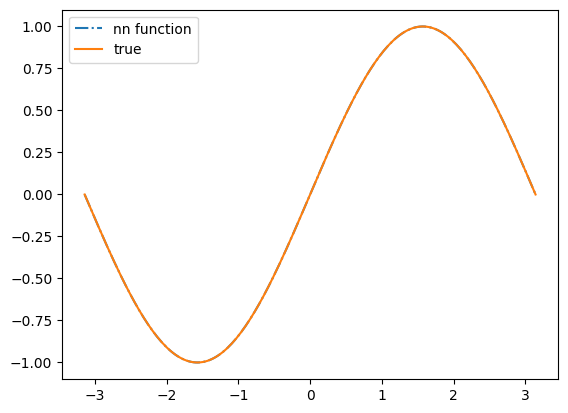

time taken:  53.17451500892639
tensor(1.0686)
tensor(0.2804)
tensor(0.0589)
tensor(0.0124)
tensor(0.0030)
tensor(0.0008)
tensor(0.0002)
tensor(5.2533e-05)


In [5]:
def target(x):
    return torch.sin(x) 
relu_dict_parameters = relu_dict(-pi,pi,2**10) # 
err_relu_list = [] 
my_model = None 
argmax_sub= False 
for num_epochs in [260]: 
    err, my_model = OGAL2FittingReLU1D(my_model,target,relu_dict_parameters, \
                    num_epochs,plot_freq = num_epochs,integration_intervals=2**10)
for i in [2,4,8,16,32,64,128,256]: 
    print(err[i])

In [ ]:
def target(x):
    return torch.sin(x) + 0.2*torch.sin(10*x)
relu_dict_parameters = relu_dict(-pi,pi,2**10) # 
err_relu_list = [] 
my_model = None 
argmax_sub= False 
for num_epochs in [260]: 
    err, my_model = OGAL2FittingReLU1D(my_model,target,relu_dict_parameters, \
                    num_epochs,plot_freq = num_epochs,integration_intervals=2**10)
for i in [2,4,8,16,32,64,128,256]: 
    print(err[i])